*Hubert Kaczyński; nr albumu 331386; grupa 101*
# **WSI laboratorium 2. Algorytmy ewolucyjne i genetyczne**

Poniżej znajdują się analizy przygotowanego przeze mnie algorytmu ewolucyjnego z selekcją ruletkową, krzyżowaniem jednopunktowym, mutacją gaussowską oraz sukcesją generacyjną.

## **Optymalizowany problem**

Algorytm ewolucyjny ma za zadanie jak najoptymalniejsze rozmieszczenie anten w sieci bezprzewodowej. Mamy do czynienia z siatką $M × M$, nałożoną na dziedzinę współrzędych anten, która reprezentuje punkty, które należy pokryć zasięgiem anten. Anteny przyjmują współrzędne z dziedziny $[0, 1] × [0, 1]$. Maksymalną ilośc anten reprezentuje parametr $n$, a zasięg anteny $R$.

Poniżej znajduje się implementacja funkcji, które pozwalają na obliczenie pokrycia siatki punktów przez podaną jej listę anten.

**UWAGA**: Funkcja coverage została napisana na podstawie funkcji podanej w treści zadania z założeniem, że przyjmuje jako argument listę wyłącznie aktywnych anten, ponieważ przy obliczaniu efektywności nie interesują nas anteny nieaktywne. W wyniku tego założenia w **całym** zadaniu występuje tylko antena w formie aktywnej.

In [1]:
import numpy as np

def grid(M):
    space = 1 / (M - 1)
    return [(i * space, j * space) for i in range(M) for j in range(M)]

def distance(antenna, point):
    return np.sqrt((antenna[0] - point[0]) ** 2 + (antenna[1] - point[1]) ** 2)

def coverage(active_antennas, M, R):
    covered_points = 0
    for point in grid(M):
        for antenna in active_antennas:
            if distance(antenna, point) <= R:
                covered_points += 1
                break
    return covered_points / M ** 2


Mając narzędzia do zmierzenia pokrycia sieci przez anteny, zaimplementowałem funkcję z treści zadania, która służy do obliczenia efektywności zaproponowanego rozmieszczenia anten z uwzględnieniem jego kosztów:

$ f(v) = w_1 * coverage(v) - w_2 * |active(v)| $

Parametry $w_1, w_2$ są wagami sterującymi. Z postaci funkcji wywnioskowałem, że najoptymalniejsze rozwiązanie, którego będzie poszukiwać algorytm ewolucyjny, to maksymalizacja funkcji $f(v)$, którą w kodzie reprezentuje funkcja efficiency:

In [2]:
def efficiency(active_antennas, w1, w2, M, R):
    return coverage(active_antennas, M, R) * w1 - len(active_antennas) * w2

## **Implementacja algorytmu ewolucyjnego**

Mając już funkcje, które pozwalają na pomiar efektywności danego rozwiązania, mogłem przystąpić do implementacji algorytmu ewolucyjnego. Podzieliłem go na następujące etapy:
- wygenerowanie losowej populacji startowej (każdy osobnik to lista współrzędnych reprezentujących umiejscowienie anten w dziedzinie),
- selekcja ruletkowa z podanej populacji,
- krzyżowanie jednopunktowe wyselekcjonowanych osobników,
- przeprowadzenie mutacji gaussowskiej na skrzyżowanych osobnikach z określonym prawdopodobieństwem,
- stworzenie głównej pętli algorytmu ewolucyjnego, która uwzględnia wszystkie hiperparametry i ewoluuje na przestrzeni wielu generacji.

### **Generacja populacji startowej**

**UWAGA:** W całym zadaniu założyłem, że populacje mają parzystą i niezerową ilość osobników, ponieważ jest to istotne przy etapie krzyżowania. Dlatego za każdym razem argumenty dotyczące rozmiarów populacji (np. przy jej tworzeniu lub selekcji) podawane są jako liczby parzyste większe od zera.

Poniżej znajduje się implementacja funkcji, która generuje listę zawierającą podaną argumentem ilość osobników, z których każdy zawiera minimum jedną i maks $n$ anten. Każda z $n$ anten ma szansę na zostanie wygenerowaną podaną w argumencie active_probability. To pozwala na testowanie rozwiązań z różnymi ilościami anten.

Założyłem, że dany osobnik nie może posiadać powtórek anten.

In [3]:
import random

def generate_population(population_size, active_probability, n):
    population = []
    for i in range(population_size):
        # initialize the first guaranteed antenna
        antennas = [(random.uniform(0, 1), random.uniform(0, 1))]

        # generate the rest of the antennas while checking the probability
        for j in range(n - 1):
            if random.uniform(0, 1) <= active_probability:
                antenna = (random.uniform(0, 1), random.uniform(0, 1))

                # check for duplicates
                if antenna not in antennas:
                    antennas.append(antenna)

        population.append(antennas)
    return population

# example
print(generate_population(2, 0.5, 2))

[[(0.5554903281895497, 0.03857512614138381), (0.04002646191728998, 0.551430290249393)], [(0.7650103037054687, 0.6489653503932111), (0.9418422936656914, 0.9920835609045179)]]


### **Selekcja ruletkowa**

W kolejnym kroku następuje selekcja ruletkowa, która polega na losowaniu osobnika spośród wszystkich osobników, gdzie prawdopodobieństwo wylosowania jest proporcjonalne do efektywności danego osobnika.

Przy przydzielaniu prawdopodobieństwa do danego osobnika występuje ryzyko ujemnej efektywności, dlatego w takim wypadku efektywności są zamieniane na dodatnie z zachowaniem proporcji. Najmniejszą efektywnośc reprezentuje wtedy mała wartość epsilon podana w argumencie funkcji. Epsilon powinien być mały, bo nie chcę zwiększać szansy na selekcję słabego osobnika.

Argument selection_size musi być mniejszy lub równy od rozmiaru populacji. Wyznacza on ile osobników zostanie wyselekcjonowanych z danej populacji.

Argument efficiencies służy do przekazania policzonych już efektywności osobników w populacji dla oszczędzenia wykonywanych w każdej iteracji głównej pętli algorytmu obliczeń.

Implementacja:

In [4]:
def roulette_selection(population, selection_size, epsilon, efficiencies):
    selected = []

    # check for negative efficiencies and convert them
    efficiency_min = min(efficiencies)
    if efficiency_min <= 0:
        efficiencies = [efficiency - efficiency_min + epsilon for efficiency in efficiencies]
    
    # perform the selection with proportional probabilities
    efficiency_sum = sum(efficiencies)
    roulette_slices = [efficiency / efficiency_sum for efficiency in efficiencies]
    for i in range(selection_size):
        selected.append(random.choices(population, weights=roulette_slices)[0])
    return selected

### **Krzyżowanie jednopunktowe**

W kolejnym kroku następuje krzyżowanie jednopunktowe. Polega ono na wymianie anten między dwoma osobnikami, zaczynając od losowo wybranej anteny w liście.

W implementacji rozważyłem przypadki, w których ilości aten różnią się między osobnikami lub ilość anten jest równa 1. Dzięki temu zawsze następuje krzyżowanie i punkt krzyżowania nie zostaje losowany poza listą.

Osobniki do krzyżowania są dobierane parami w kolejności wynikającej z wykonywanej wcześniej selekcji ruletkowej, co zwiększa szanse na krzyżowanie lepszego osobnika z lepszym.

Implementacja:

In [5]:
def single_point_crossover(selected_population):
    crossed_population = []
    for i in range(0, len(selected_population) - 1, 2):

        # pick parents from the selected population while keeping their order
        parent1 = selected_population[i]
        parent2 = selected_population[i + 1]
        
        # check if any of the parents has only one antenna which allows for a simplified crossover
        if len(parent1) == 1 or len(parent2) == 1:
            child1 = parent2
            child2 = parent1

        # perform the crossover while making sure the crossover point is not out of range
        else:
            crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
        crossed_population.append(child1)
        crossed_population.append(child2)
    return crossed_population

# example
print(single_point_crossover([[(0, 0), (1, 1), (0.5, 0.5)], [(0.22, 0.22), (0.4, 0.4)]]))

[[(0, 0), (0.4, 0.4)], [(0.22, 0.22), (1, 1), (0.5, 0.5)]]


### **Mutacja gaussowska**

W kolejnym kroku następuje mutacja, polegająca na wprowadzeniu losowych zmian do niektóych osobników. Prawdopodobieństwo nastąpienia mutacji powinno być relatywnie niskie i jest określone w implementacji argumentem mutation_probability.

W ramach implementacji tego zadania zastosowana zostanie **mutacja gaussowska**, polegająca na dodaniu do aktualnych wartości współrzędnych anten danego osobnika wektora liczb losowych z rozkładu normalnego, przeskalowanego przez tzw. siłę mutacji określoną w implementacji argumentem mutation_strength.

Implementacja:

In [6]:
def gaussian_mutation(crossed_population, mutation_probability, mutation_strength):
    mutated_population = []
    for antenna_set in crossed_population:
        mutant = []
        for antenna in antenna_set:

            # perform the mutation if the probability is met
            if random.uniform(0, 1) <= mutation_probability:
                mutated = (
                    np.clip(antenna[0] + random.gauss(0, mutation_strength), 0, 1),
                    np.clip(antenna[1] + random.gauss(0, mutation_strength), 0, 1)
                )
                mutant.append(mutated)
            else:
                mutant.append(antenna)
        mutated_population.append(mutant)
    return mutated_population

# example
print(gaussian_mutation([[(0, 0), (1, 1), (0.5, 0.5)]], 0.5, 0.5))

[[(0.0, 0.0), (1, 1), (0.8151448147552018, 0.287054217736353)]]


### **Główna pętla algorytmu**

Główna pętla łączy wszystkie poprzednie etapy w jedno wykonanie. Odbywa się ono na tej samej populacji podaną argumentem generations ilośc razy. W zadaniu wybrana została sukcesja generacyjna, która po przeprowadzeniu modyfikacji na populacji przekopiowuje bez zmian otrzymane osobniki do następnej generacji. Ułatwia to implementacje, ale stwarza ryzyko bezpowrotnej utraty osobników, które osiągały bardzo dobre wyniki w poprzedniej generacji.

Częśc argumentów posiada domyślne wartości wzięte z treści zadania.

Funkcja evolution_algorithm przyjmuje jako argumenty ilośc generacji oraz wszystkie potrzebne parametry z opisanych wcześniej funkcji:

In [7]:
def evolution_algorithm(generations, population_size, generate_active_probability, selection_size, selection_epsilon, mutation_probability, mutation_strength, w1=10, w2=1, R=0.25, n=10, M=100):
    
    # generate the initial population and variables
    population = generate_population(population_size, generate_active_probability, n)
    max_efficiency = float('-inf')
    efficiencies = []

    # calculate the initial efficiencies of every antenna set in the population
    efficiencies = [efficiency(antenna_set, w1, w2, M, R) for antenna_set in population]

    # main loop
    for i in range(generations):

        # perform each step of the algorithm
        selected_population = roulette_selection(population, selection_size, selection_epsilon, efficiencies)
        crossed_population = single_point_crossover(selected_population)
        mutated_population = gaussian_mutation(crossed_population, mutation_probability, mutation_strength)

        # update the population and efficiencies with the evolved ones
        population = mutated_population
        efficiencies = [efficiency(antenna_set, w1, w2, M, R) for antenna_set in population]

        # update best results
        generation_max_efficiency = max(efficiencies)
        if generation_max_efficiency > max_efficiency:
            max_efficiency = generation_max_efficiency
            best_index = efficiencies.index(generation_max_efficiency)
            best_result = population[best_index]
    return max_efficiency, best_result

## **Analiza działania algorytmu**

Poniżej znajdują się eksperymenty i pomiary zaimplementowanego przeze mnie algorytmu ewolucyjnego.

Do pomiarów czasu i efektywności używam funkcji evolution_algorithm, natomiast do zobrazowania działania używam lekko zmodyfikowanej wersji evolution_algorithm_print, która dodatkowo wyświetla dane w trakcie działania. Robię to aby uniknąć dodatkowych zakłóceń podczas pomiarów.

Zmodyfikowana funkcja evolution_algorithm_print:

In [8]:
def evolution_algorithm_print(generations, population_size, generate_active_probability, selection_size, selection_epsilon, mutation_probability, mutation_strength, details=False, w1=10, w2=1, R=0.25, n=10, M=100):
    population = generate_population(population_size, generate_active_probability, n)
    max_efficiency = float('-inf')
    efficiencies = []
    for antenna_set in population:
        efficiencies.append(efficiency(antenna_set, w1, w2, M, R))
    for i in range(generations):
        selected_population = roulette_selection(population, selection_size, selection_epsilon, efficiencies)
        crossed_population = single_point_crossover(selected_population)
        mutated_population = gaussian_mutation(crossed_population, mutation_probability, mutation_strength)
        population = mutated_population
        efficiencies = [efficiency(antenna_set, w1, w2, M, R) for antenna_set in population]
        generation_max_efficiency = max(efficiencies)
        if details:
            print(f'{i} generation best: {generation_max_efficiency}')
        if generation_max_efficiency > max_efficiency:
            best_generation = i
            max_efficiency = generation_max_efficiency
            best_index = efficiencies.index(generation_max_efficiency)
            best_result = population[best_index]
    print(f'best generation: {best_generation}, best result: {max_efficiency}')
    return best_result

### **Wizualizacja pętli algorytmu**

Jako domyśle wartości argumentów nieokreślonych w poleceniu przyjmuję:
- generations = 30
- population_size = 20
- generate_active_probability = 0.5
- selection_size = 20
- selection_epsilon = 0.01
- mutation_probability = 0.2
- mutation_strength= 0.05

Przykładowy przebieg pętli algorytmu:

In [13]:
print(evolution_algorithm_print(30, 20, 0.5, 20, 0.01, 0.2, 0.05, True))

0 generation best: 1.5259999999999998
1 generation best: 2.585000000000001
2 generation best: 2.439
3 generation best: 2.439
4 generation best: 2.071999999999999
5 generation best: 2.439
6 generation best: 2.447000000000001
7 generation best: 2.314
8 generation best: 2.3089999999999993
9 generation best: 2.667
10 generation best: 3.157
11 generation best: 2.8230000000000004
12 generation best: 2.8400000000000007
13 generation best: 2.8930000000000007
14 generation best: 2.944
15 generation best: 3.247
16 generation best: 3.1389999999999993
17 generation best: 3.24
18 generation best: 3.4029999999999996
19 generation best: 3.462999999999999
20 generation best: 3.3939999999999992
21 generation best: 3.287
22 generation best: 3.4589999999999996
23 generation best: 3.3440000000000003
24 generation best: 3.266
25 generation best: 3.1850000000000005
26 generation best: 3.3839999999999995
27 generation best: 3.3119999999999994
28 generation best: 3.4480000000000004
29 generation best: 3.449
b

Przykładowy przebieg pętli dla innego hiperparametru (R = 0.4):

In [14]:
print(evolution_algorithm_print(30, 20, 0.5, 20, 0.01, 0.2, 0.05, True, R=0.4))

0 generation best: 4.694000000000001
1 generation best: 4.694000000000001
2 generation best: 4.695
3 generation best: 4.699999999999999
4 generation best: 4.853
5 generation best: 4.884
6 generation best: 4.884
7 generation best: 4.7780000000000005
8 generation best: 4.644
9 generation best: 5.529999999999999
10 generation best: 5.529999999999999
11 generation best: 5.399999999999999
12 generation best: 5.529999999999999
13 generation best: 5.567
14 generation best: 5.335000000000001
15 generation best: 5.452
16 generation best: 5.522
17 generation best: 5.522
18 generation best: 5.478
19 generation best: 5.359
20 generation best: 5.671999999999999
21 generation best: 5.757999999999999
22 generation best: 5.7509999999999994
23 generation best: 5.661999999999999
24 generation best: 5.65
25 generation best: 5.724
26 generation best: 5.651
27 generation best: 5.633000000000001
28 generation best: 5.497999999999999
29 generation best: 5.520999999999999
best generation: 21, best result: 5.7

#### **Wniosek**

Jak widać powyżej, wartości hiperparametrów mogą wpływać znacząco na wynik działania algorytmu. Dlatego w dalszej części przedstawię wpływ poszczególnych parametrów na czas wykonywania i jakośc wyniku (średnie wartości dla wielu wykonań).

Do zobrazowania wyników będę używał poniższego kodu, który odpowiada za tworzenie wykresów, Pozwala on na zobrazowanie zachowania algorytmu w zależności od różnych wartości danego w argumencie parametru, pozostawiając resztę parametrów na wartościach domyślnych.

Dla każdej wartości sprawdzanego parametru wyciągana jest średnia wyników z pięciu wykonań algorytmu:

In [39]:
import time
import matplotlib.pyplot as plt

# set default paramater values
parameters = {
    "generations": 30,
    "population_size": 20,
    "generate_active_probability": 0.5,
    "selection_size": 20,
    "selection_epsilon": 0.01,
    "mutation_probability": 0.2,
    "mutation_strength": 0.05,
    "w1": 10,
    "w2": 1, 
    "R": 0.25,
    "n": 10,
    "M": 100,
}

def run_analysis(parameter, min_value, max_value, step):
    parameter_values = np.arange(min_value, max_value, step)
    results = []
    results_time = []
    results_antenna_count = []

    for value in parameter_values:
        result_sum = 0
        time_sum = 0
        antenna_count = 0

        # perform multiple measurements
        for i in range(5):
            now = time.time()
            result = evolution_algorithm(**{**parameters, parameter: value})
            time_sum += time.time() - now
            result_sum += result[0]
            antenna_count += len(result[1])

        # add average results
        results.append(result_sum / 5)
        results_time.append(time_sum / 5)
        results_antenna_count.append(antenna_count / 5)
    
    fig = plt.figure(figsize=(14, 14))

    # create the plot showing efficiency measruements
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(parameter_values, results)
    ax.set_title(f"Średnia efektywność wyniku w zależności od parametru {parameter}")
    ax.set_xlabel(f"Wartość parametru {parameter}")
    ax.set_ylabel("Średnia efektywność wyniku")
    ax.grid(alpha=0.5)

    # create the plot showing time measurements
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(parameter_values, results_time)
    ax2.set_title(f"Średni czas działania w zależności od parametru {parameter}")
    ax2.set_xlabel(f"Wartość parametru {parameter}")
    ax2.set_ylabel("Średni czas działania [s]")
    ax2.grid(alpha=0.5)

    # create the plot showing antenna number measurements
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(parameter_values, results_antenna_count)
    ax3.set_title(f"Średnia liczba anten w zależności od parametru {parameter}")
    ax3.set_xlabel(f"Wartość parametru {parameter}")
    ax3.set_ylabel("Średnia liczba anten")
    ax3.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

### **Parametr generation_size**

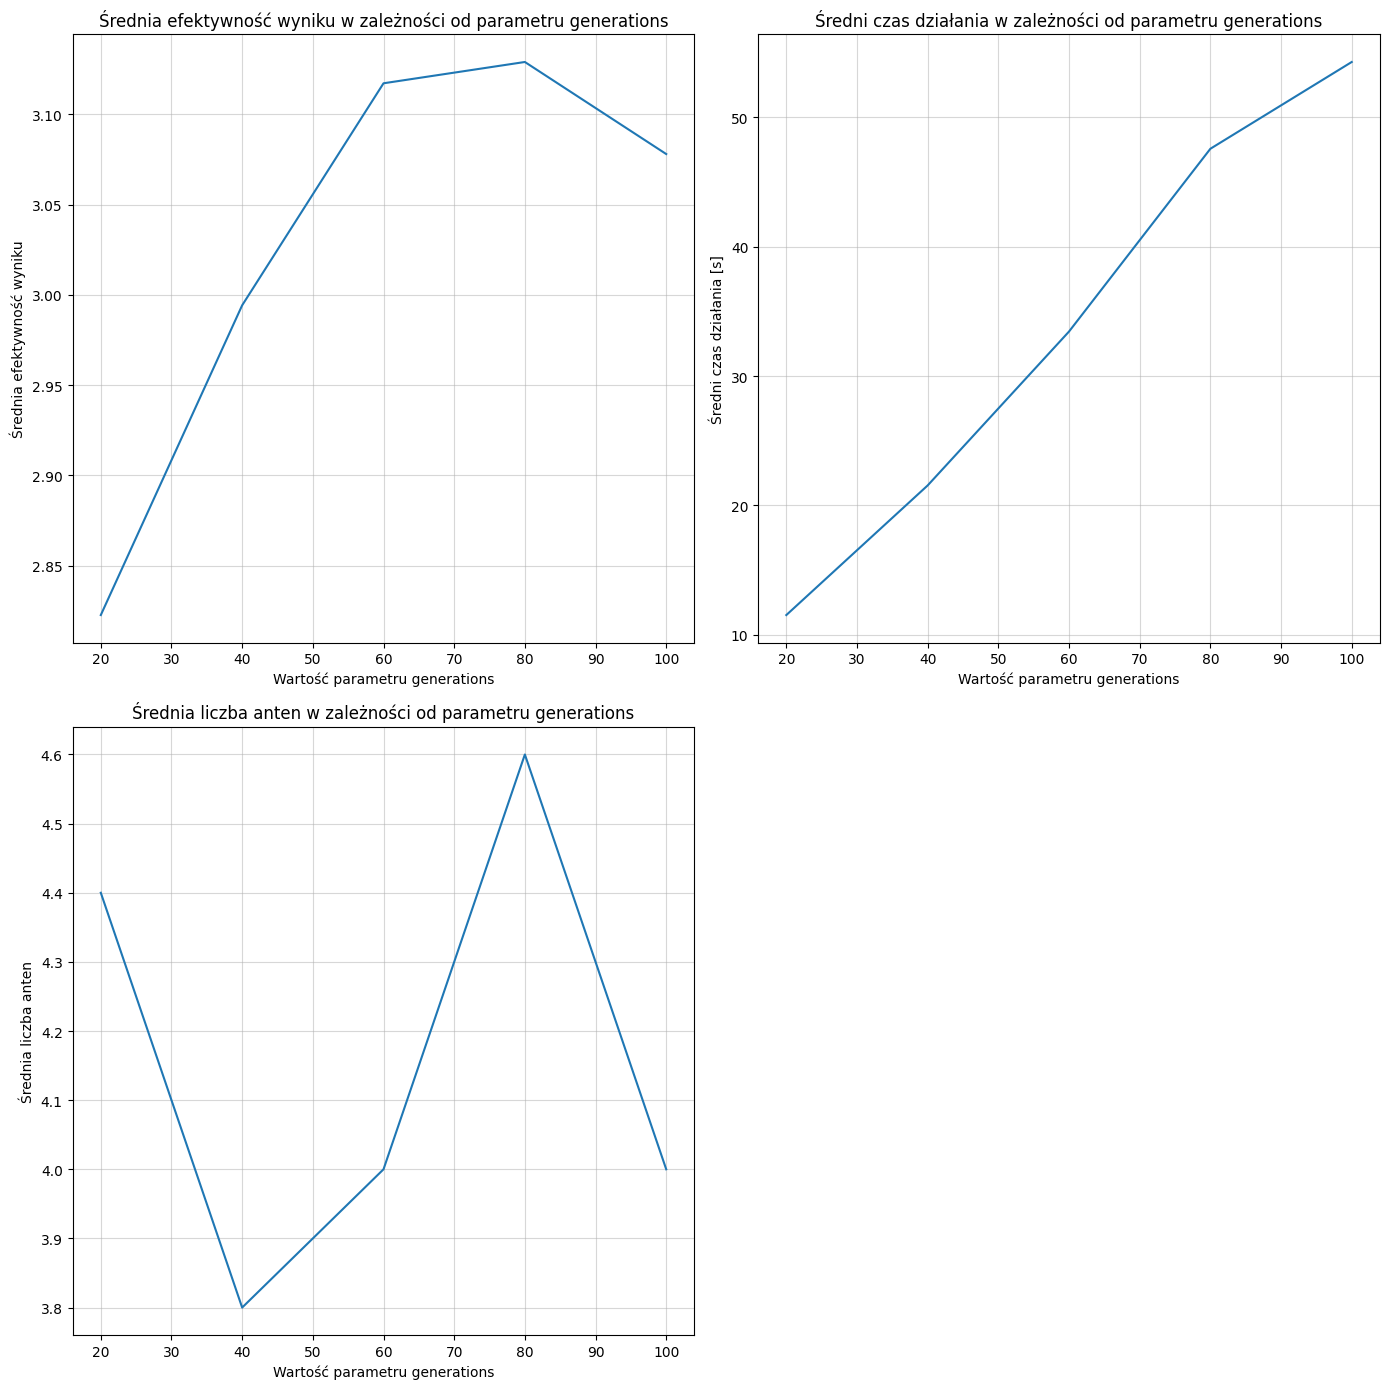

In [40]:
run_analysis("generations", 20, 120, 20)

#### **Wnioski**

Zgodnie z moimi przewidywaniami więcej generacji daje szanse algorytmowi na znalezienie lepszego rozwiązania więc wykres pierwszy ma charakter rosnący. Jendkże na końcu jakośc rozwiązania lekko spada. Może to wynikać z tego, że algorytm posiada wiele elementów losowych oraz sukcesję generacyjną. Przez to, niefortunne losowanie może zupełnie nadpisać dobre wyniki z poprzednuch generacji.

Na wykresie drugim widać, że im więcej generacji tym więcej czasu zajmuje wykonanie obliczeń algorytmu, co zdaje się oczywiste, bo każda generacja oznacza dodatkowe wykonanie iteracji pętli głównej algorytmu.

Wykres trzeci nie daje jasnej zależności między ilością anten a ilością generacji. Można jednak zauważyć, że ilośc anten oscyluje wokół wartości 4. To sugeruje, że jest to optymalna ilość anten dla wielu przypadków.

### **Parametr population_size**

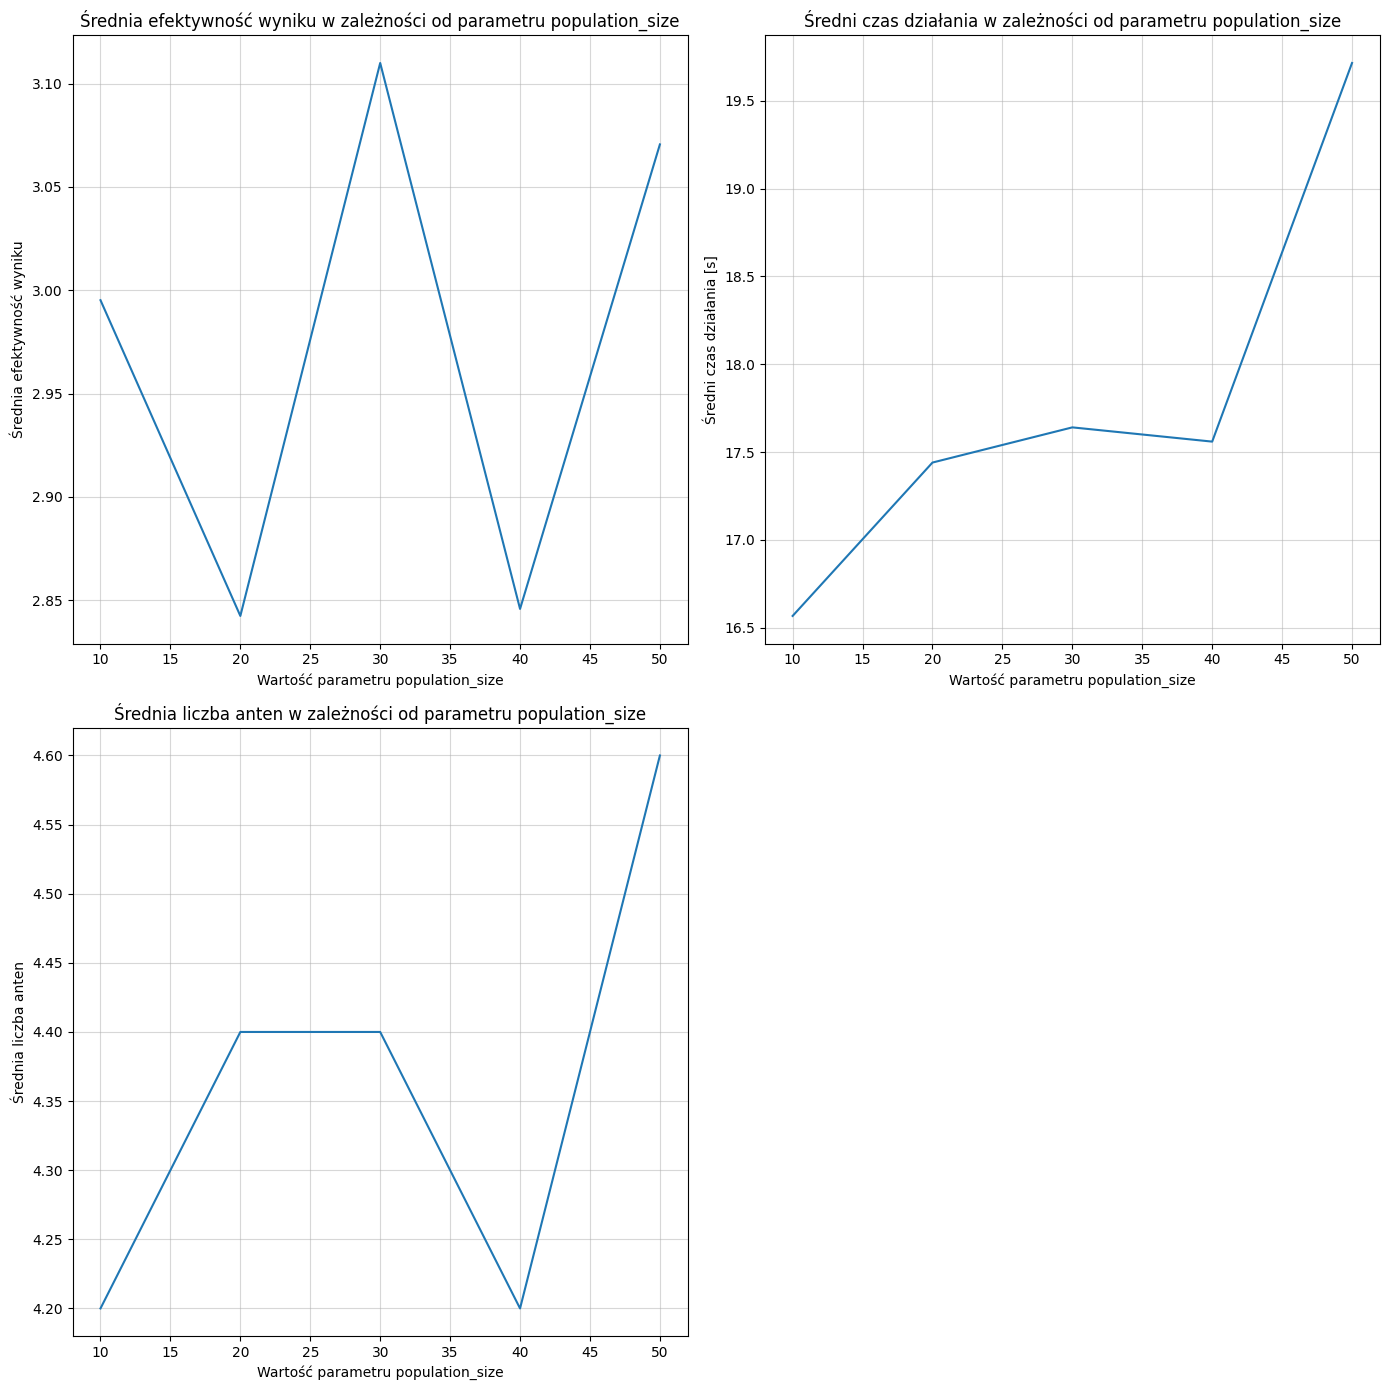

In [41]:
run_analysis("population_size", 10, 60, 10)

#### **Wnioski**

Z pierwszego wykresu można wywnioskować, że wielkośc populacji nie pogarsza lub polepsza jednoznacznie jakości rozwiązania. Wynika to zapewne z tego, że jest to wysoce losowy czynnik. Duża pula osobników tak samo zwiększa szansę na wylosowanie dobrych jak i złych osobników.

Z wykresu drugiego wynika, że czas wykonania się zwiększa wraz ze zwiększeniem populacji. Ma to sens, ponieważ więcej osobników oznacza większą ilość anten do sprawdzenia przez program w każdym kroku.

Z wykresu trzeciego wynika, że dla dowolnie dużych populacji ilośc anten w finalnym rozwiązaniu to około 4 lub 5.

### **Parametr generate_acitve_probability**

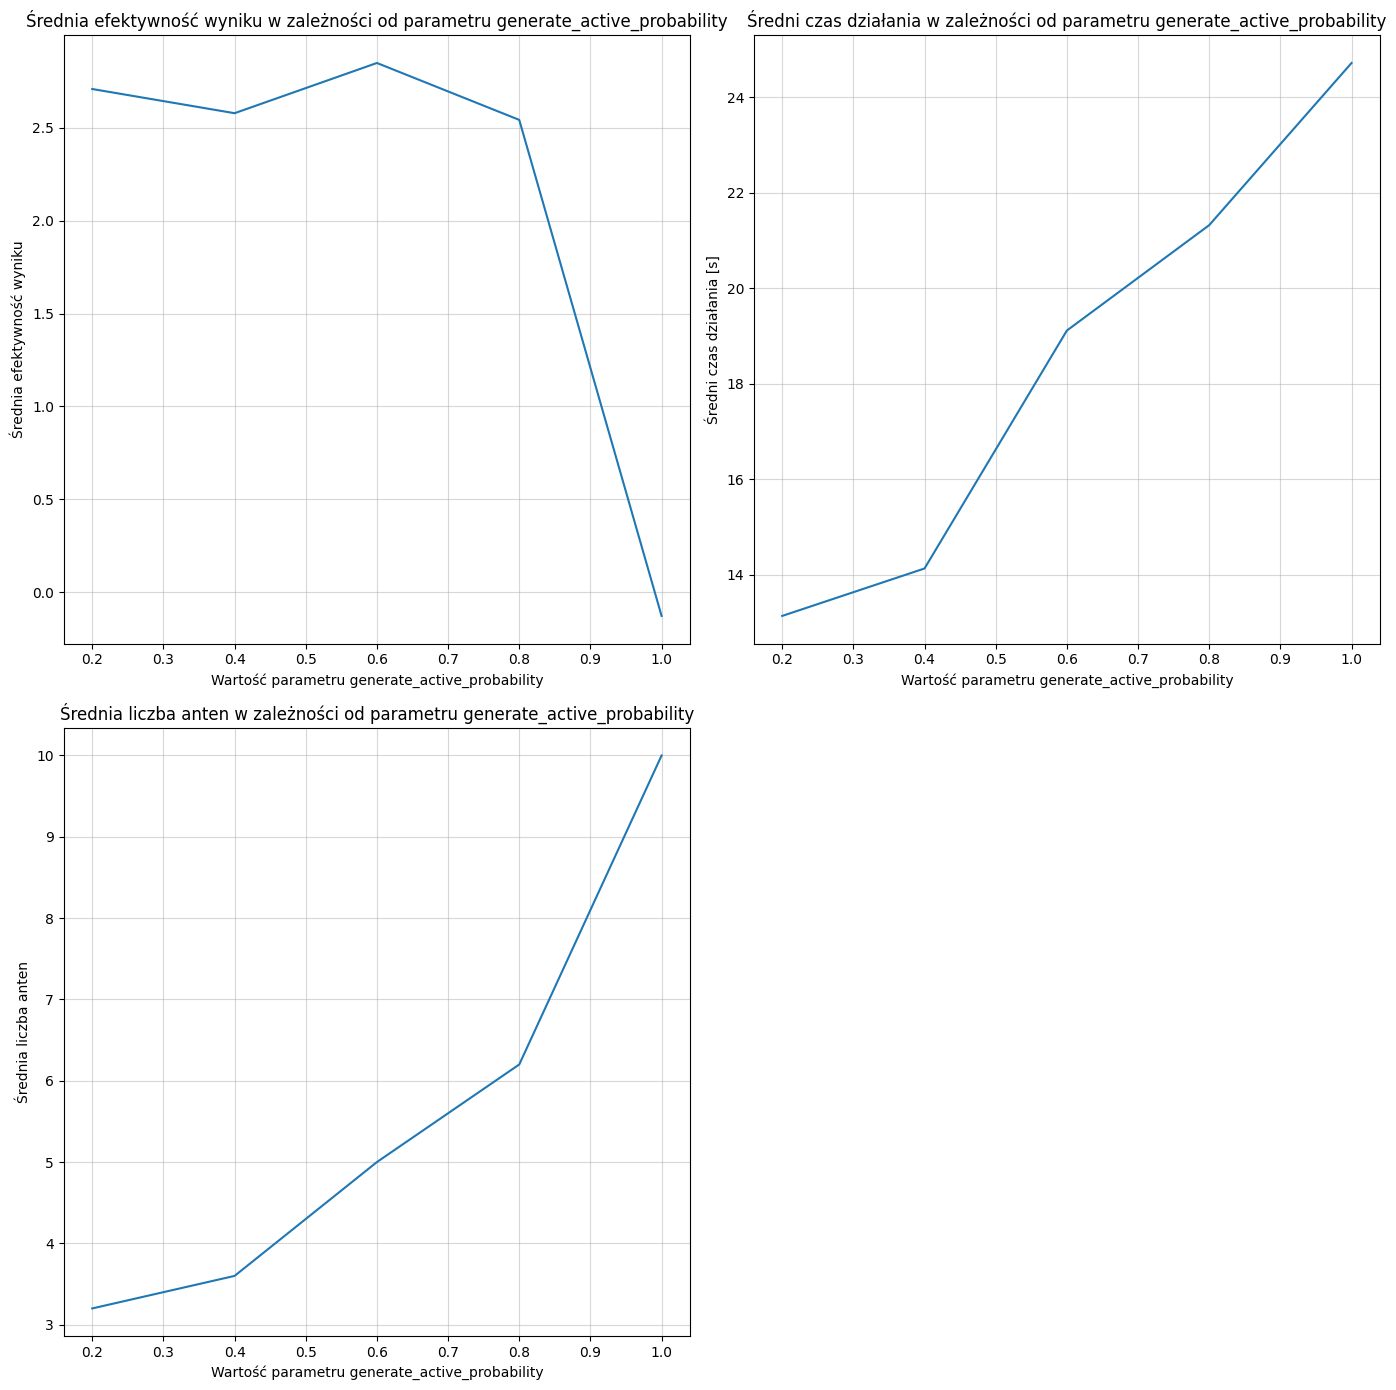

In [42]:
run_analysis("generate_active_probability", 0.2, 1.2, 0.2)

#### **Wnioski**

Jako że ilość anten bezpośrednio wpływa na koszt rozwiązania, to wykres pierwszy pokazuje słuszną zależność - więcej aktywnych anten obniża jakośc rozwiązania. Nie jest to balansowane większym pokryciem, ponieważ jak pokazały poprzednie wyniki, wystarczy około 4, 5 anten żeby sensownie pokryć sieć.

Więcej anten zwiększy czas działania algorytmu, bo program będzie musiał sprawdzać większą ilość współrzędnych podczas działania, co zgadza się z wykresem drugim.

Wykres trzeci pokazuje oczywistą zależność - im większe prawdopodobieństwo wystąpienia antenty tym więcej pojawi się anten.

### **Parametr selection_size**

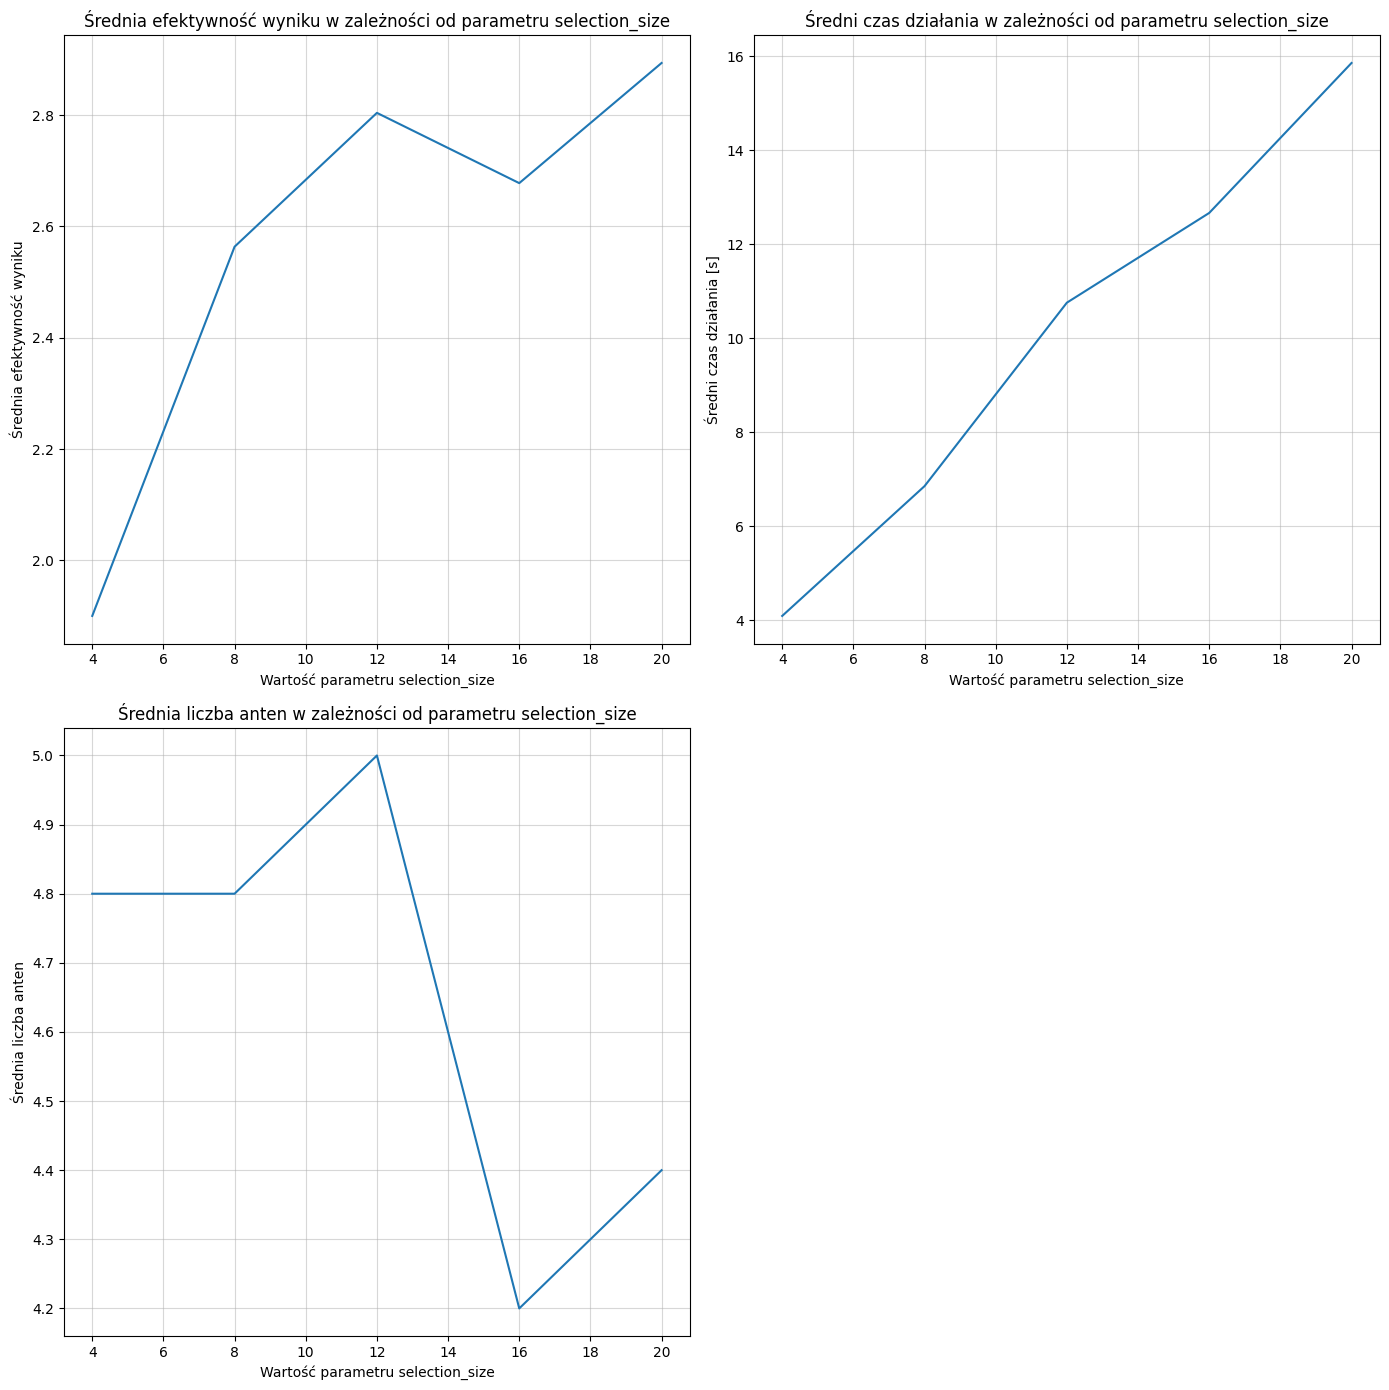

In [43]:
run_analysis("selection_size", 4, 24, 4)

#### **Wnioski**

Z wykresu pierwszego wynika, że danie selekcji ruletkowej większej ilości szans na dobór osobników pozytywnie wpływa na jakośc wyniku algorytmu. Ma to sens, ponieważ selekcja ruletkowa ma największą szansę na wylosowanie dobrych osobników.

Drugi wykres pokazuje zależność rosnącego czasu wykonania dla dużego rozmiaru selekcji. Wynika to z tego, że mała selekcja zmniejsza badaną populacje, zmniejszając tym samym ilośc wymaganych obliczeń i porównań między osobnikami.

Ilośc anten podobnie jak w poprzednich analizach trzyma się między 4 a 5. Jednakże dla lepszych rozwiązań średnia liczba anten zbliża się do 4.

### **Parametr mutation_probability**

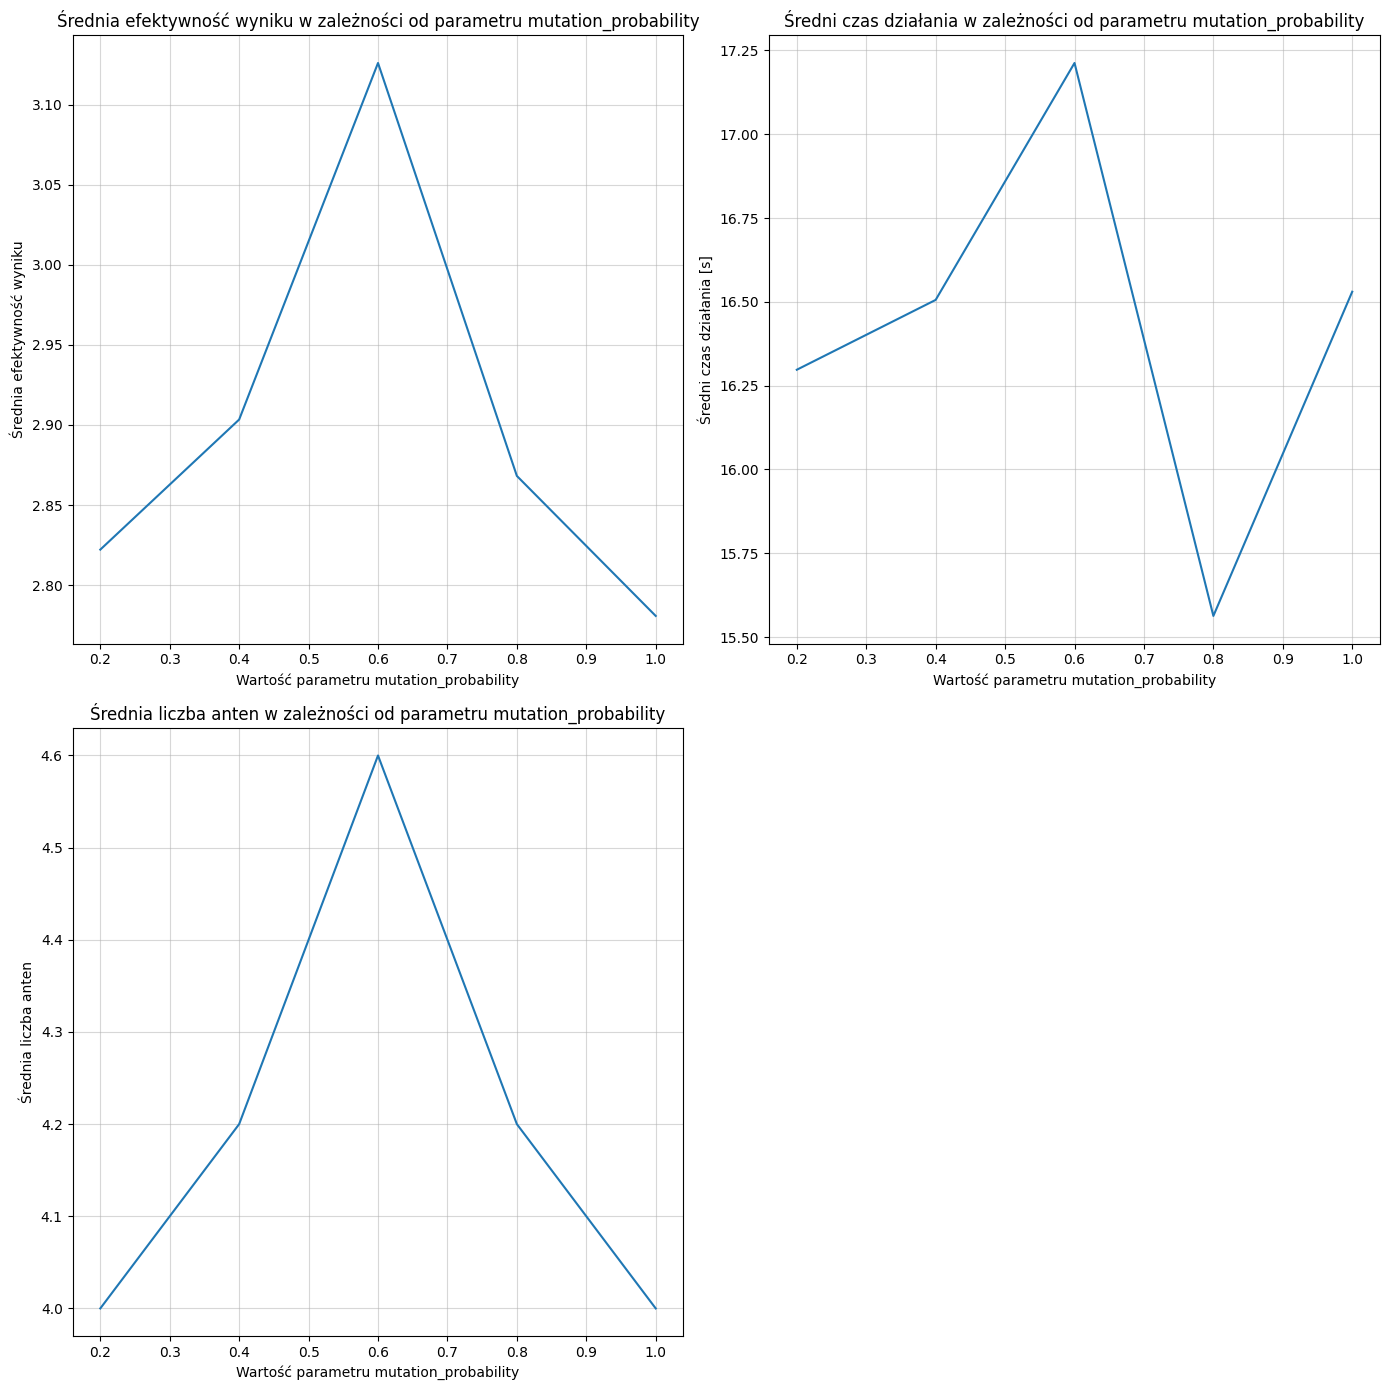

In [44]:
run_analysis("mutation_probability", 0.2, 1.2, 0.2)

#### **Wnioski**

Z wykresu pierwszego i trzeciego wynika, że zarówno nalepsza efektywność jak i największa ilość anten przypada dla szansy mutacji ok. 50%.

Z wykresu drugiego wynika, że wpływ ilości mutacji na czas wykonania algorytmu jest pomijalny. Ma to sens, ponieważ mutacja jest małym i nieskomplikowanym elementem całego algorytmu, który wystepuje tylko w jednym kroku.

### **Parametr mutation_strength**

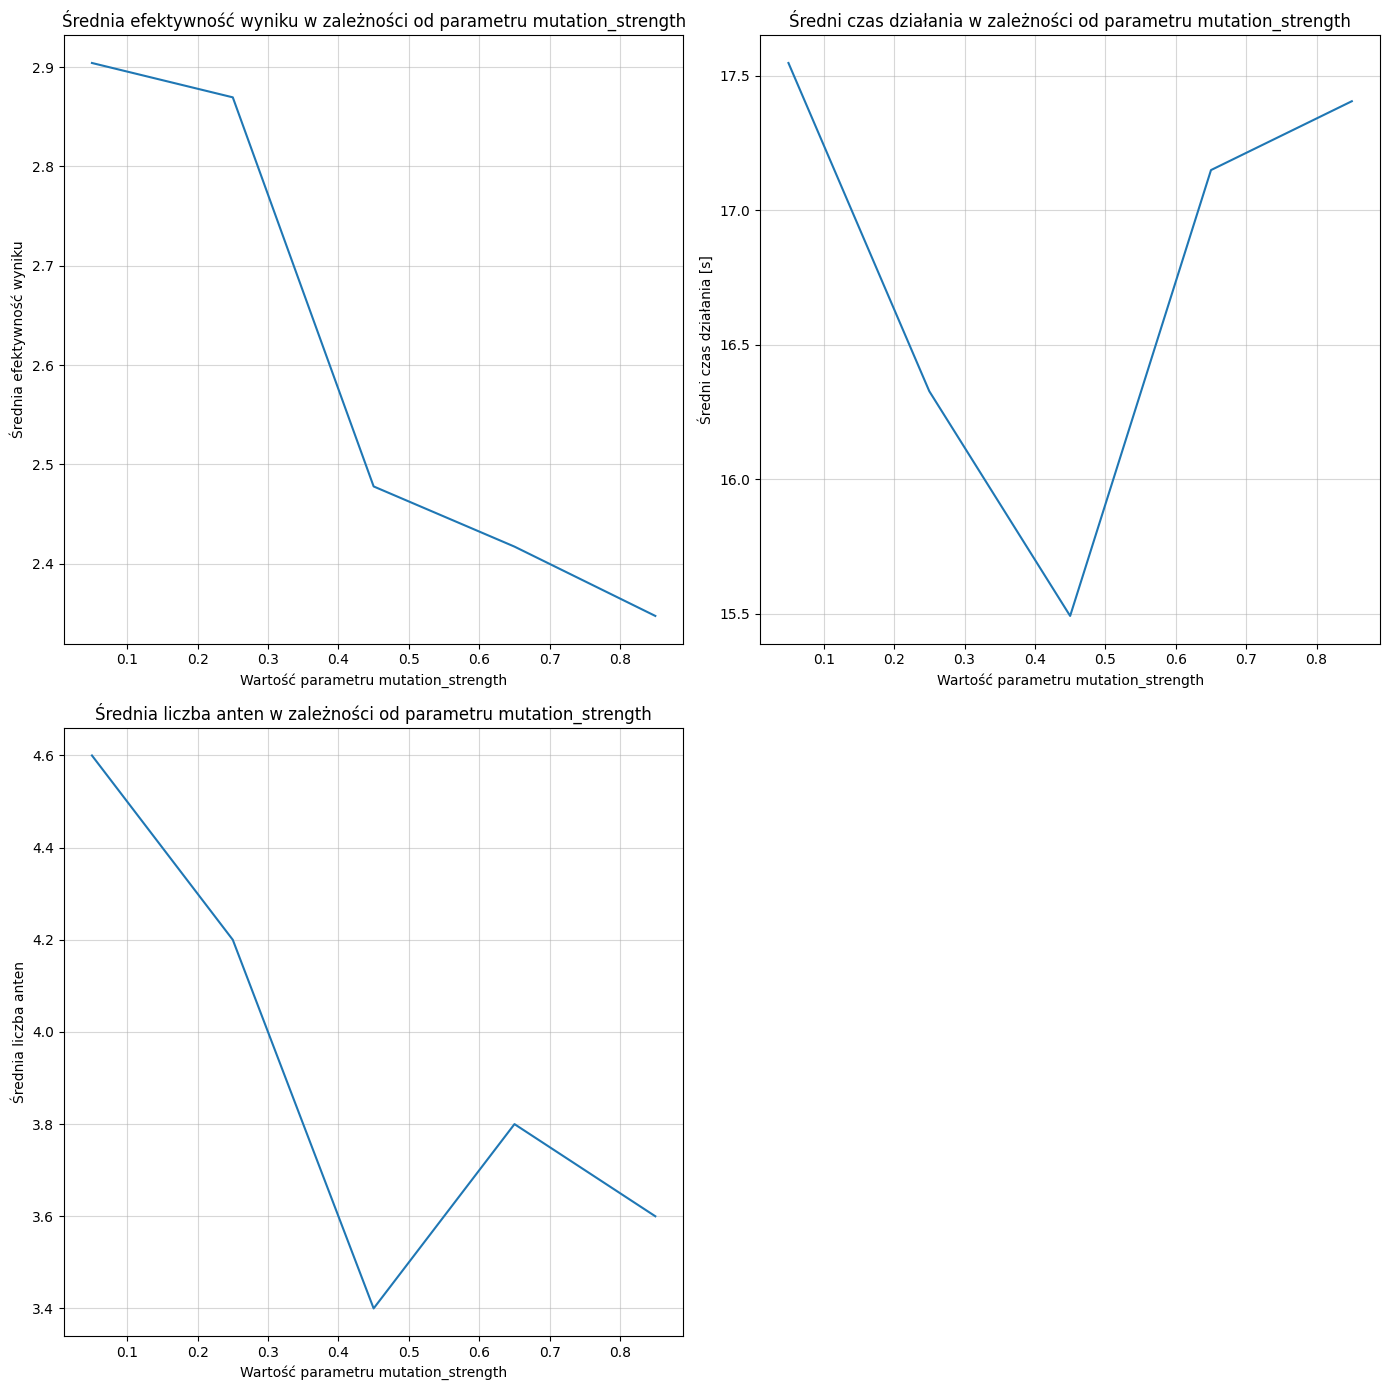

In [45]:
run_analysis("mutation_strength", 0.05, 1.05, 0.2)

#### **Wnioski**

Z wykresu pierwszego wynika, że jakośc rozwiązania spada wraz z wzrostem siły mutacji. Ma to sens, ponieważ mutacja w większej ilości przypadków przesunie antenę w niepożądanym kierunku. Dlatego zwiększając jej siłę sprawiam, że te negatywne kierunki mają większy wpływ na wynik.

Z drugiego wykresu wynika, że wpływ na czas jest pomijalny, podobnie jak we wnioskach na temat prawdopodobieństwa mutacji.

Z trzeciego wykresu wynika, że im mniejsza siła mutacji tym mniej anten używa rozwiązanie algorytmu. Może to wynikać zarówno z tego, że antena została przesunięta w bardzo dobrym kierunku i ewolucja pozbyła się innych słabych anten, jak i z tego że została przesunięta w złym kierunku więc ewolucji udało się jej pozbyć. Mutacja jest bardzo losowym czynnikiem.

### **Parametr $w1$**

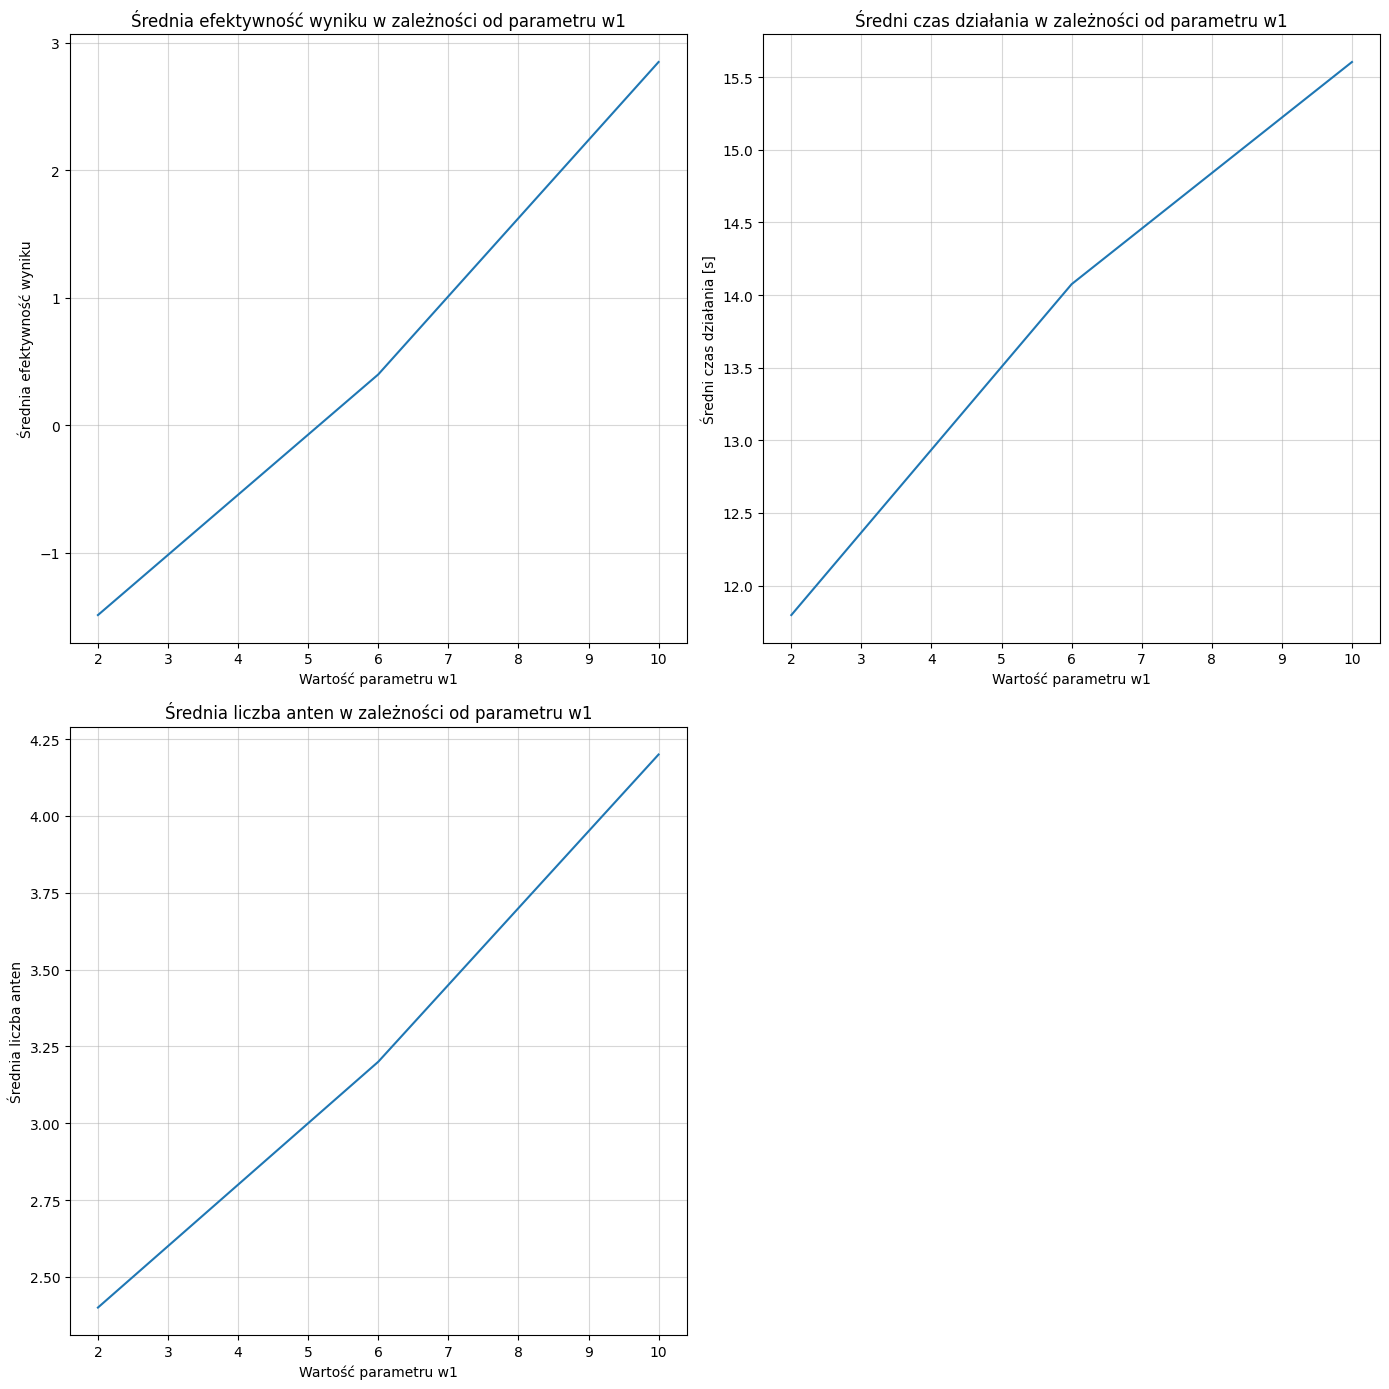

In [46]:
run_analysis("w1", 2, 12, 4)

#### **Wnioski**

Parametr $w1$ premiuje stopień pokrycia sieci przez anteny. Oczywiste wydają się więc wyniki pierwszego i drugiego wykresu. Im większe będzie $w1$ tym zwiększy się premia z pokrycia sieci i tym samym zwiększy się efektywnośc wyniku. Programowi opłaca się użyć większej ilości anten, bo pokrycie jest tym korzystniejsze i przeważa nad kosztem.

Wykres drugi pokazuje, że wpływ parametru na czas jest pomijalny, bo zmienia jedynie składnik działania obliczającego efektywność rozwiązania.

### **Parametr $w2$**

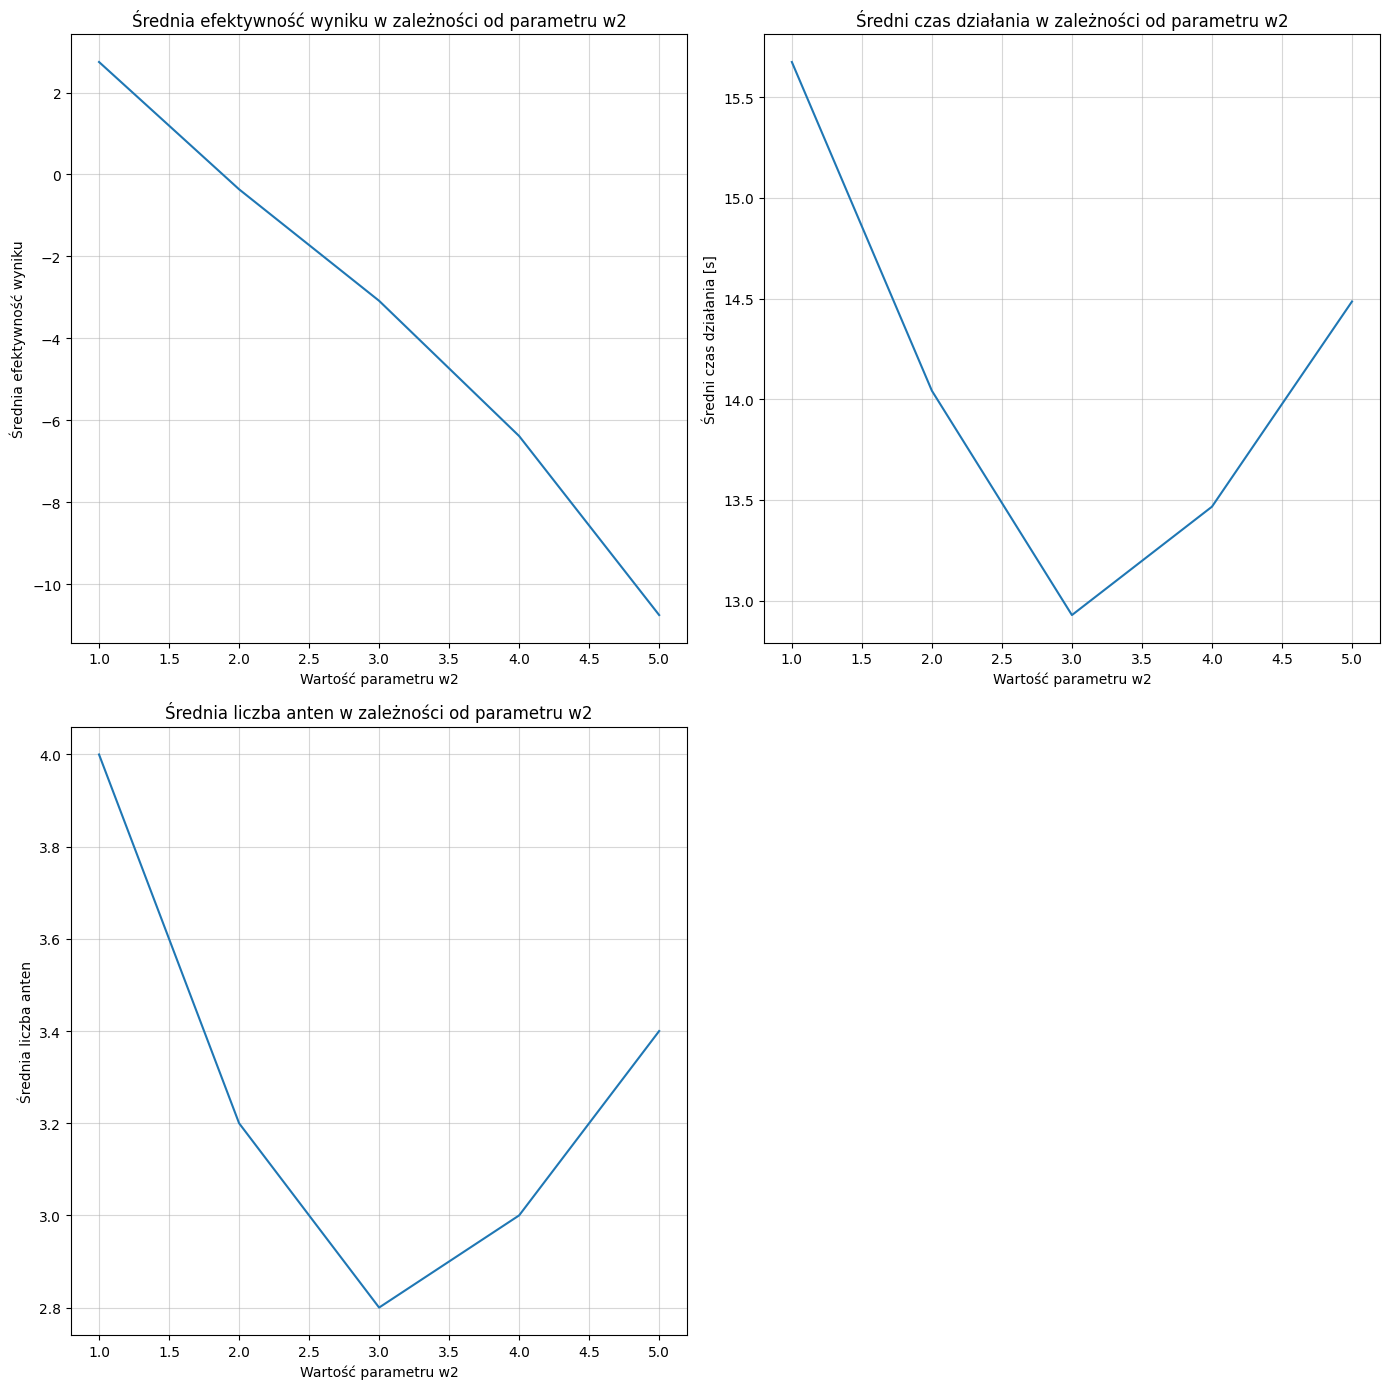

In [47]:
run_analysis("w2", 1, 6, 1)

#### **Wnioski**

Z wykresu pierwszego wynika, że efektywność rozwiązań drastycznie spada wraz ze zwiększeniem $w2$, co ma sens bo zwiększa to koszt rozstawienia anten.

Wykres drugi pokazuje, że podobnie jak dla $w1% wpływ na czas jest pomijalny.

Wykres trzeci cechuje się mniejszą ilością użytych anten w porównaniu do wyników dla domyślnych parametrów. Wynika to zapewne z tego, że populacja ewoluuje tak, aby usunąć jak najwięcej anten, bo są droższe wraz ze wzrostem $w2$.

### **Parametr $R$**

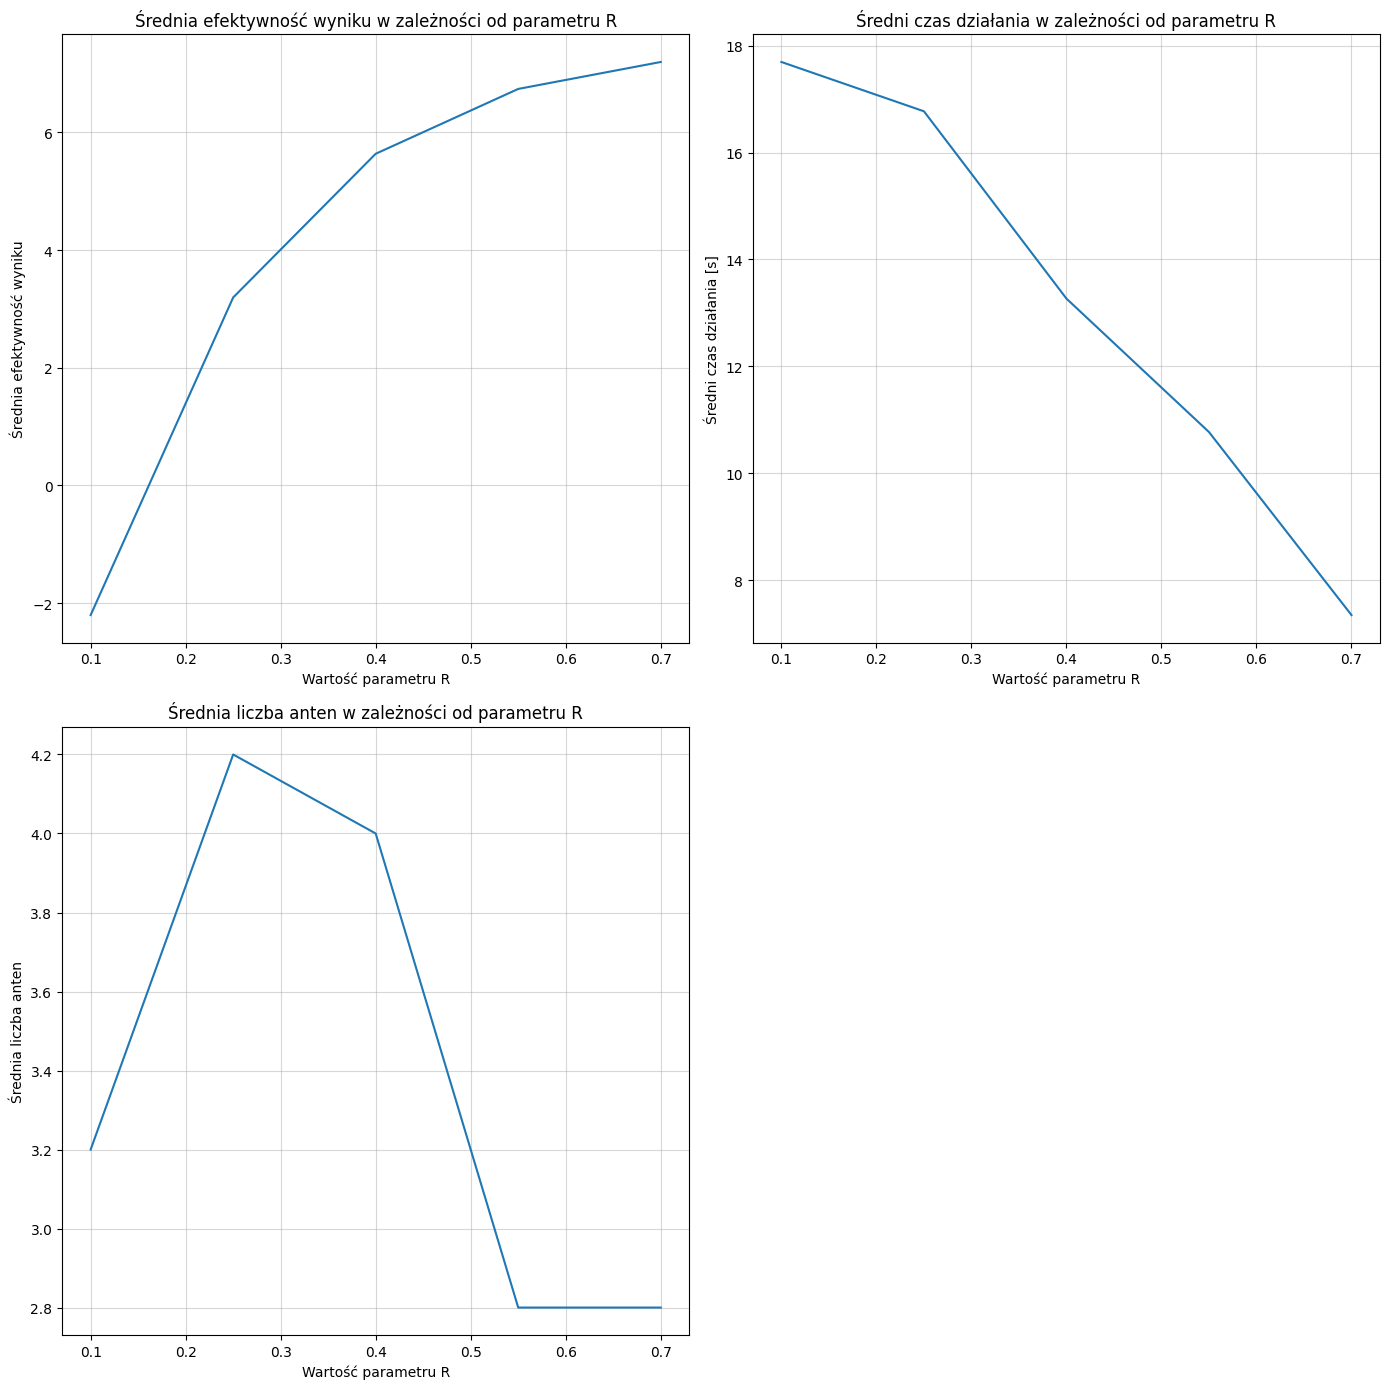

In [51]:
run_analysis("R", 0.1, 0.85, 0.15)

#### **Wnioski**

Wykres pierwszy jasno pokazuje, że większy promień zasięgu działania anten wpływa korzystnie na wynik, bo łatwiej pokryć sieć. Prawdą jest też to, że każda antena jest lepsza więc można użyć ich mniej, co obrazuje wykres trzeci.

Wykres drugi pokazuje, że wraz ze wzrostem promienia zmniejsza się czas wykonywania algorytmu. Może to wynikać z tego, że algorytm szybciej znajduje dobre rozwiązanie więc nie musi wykonywać dużej ilości kolejnych porównań i zamian.

### **Parametr $n$**

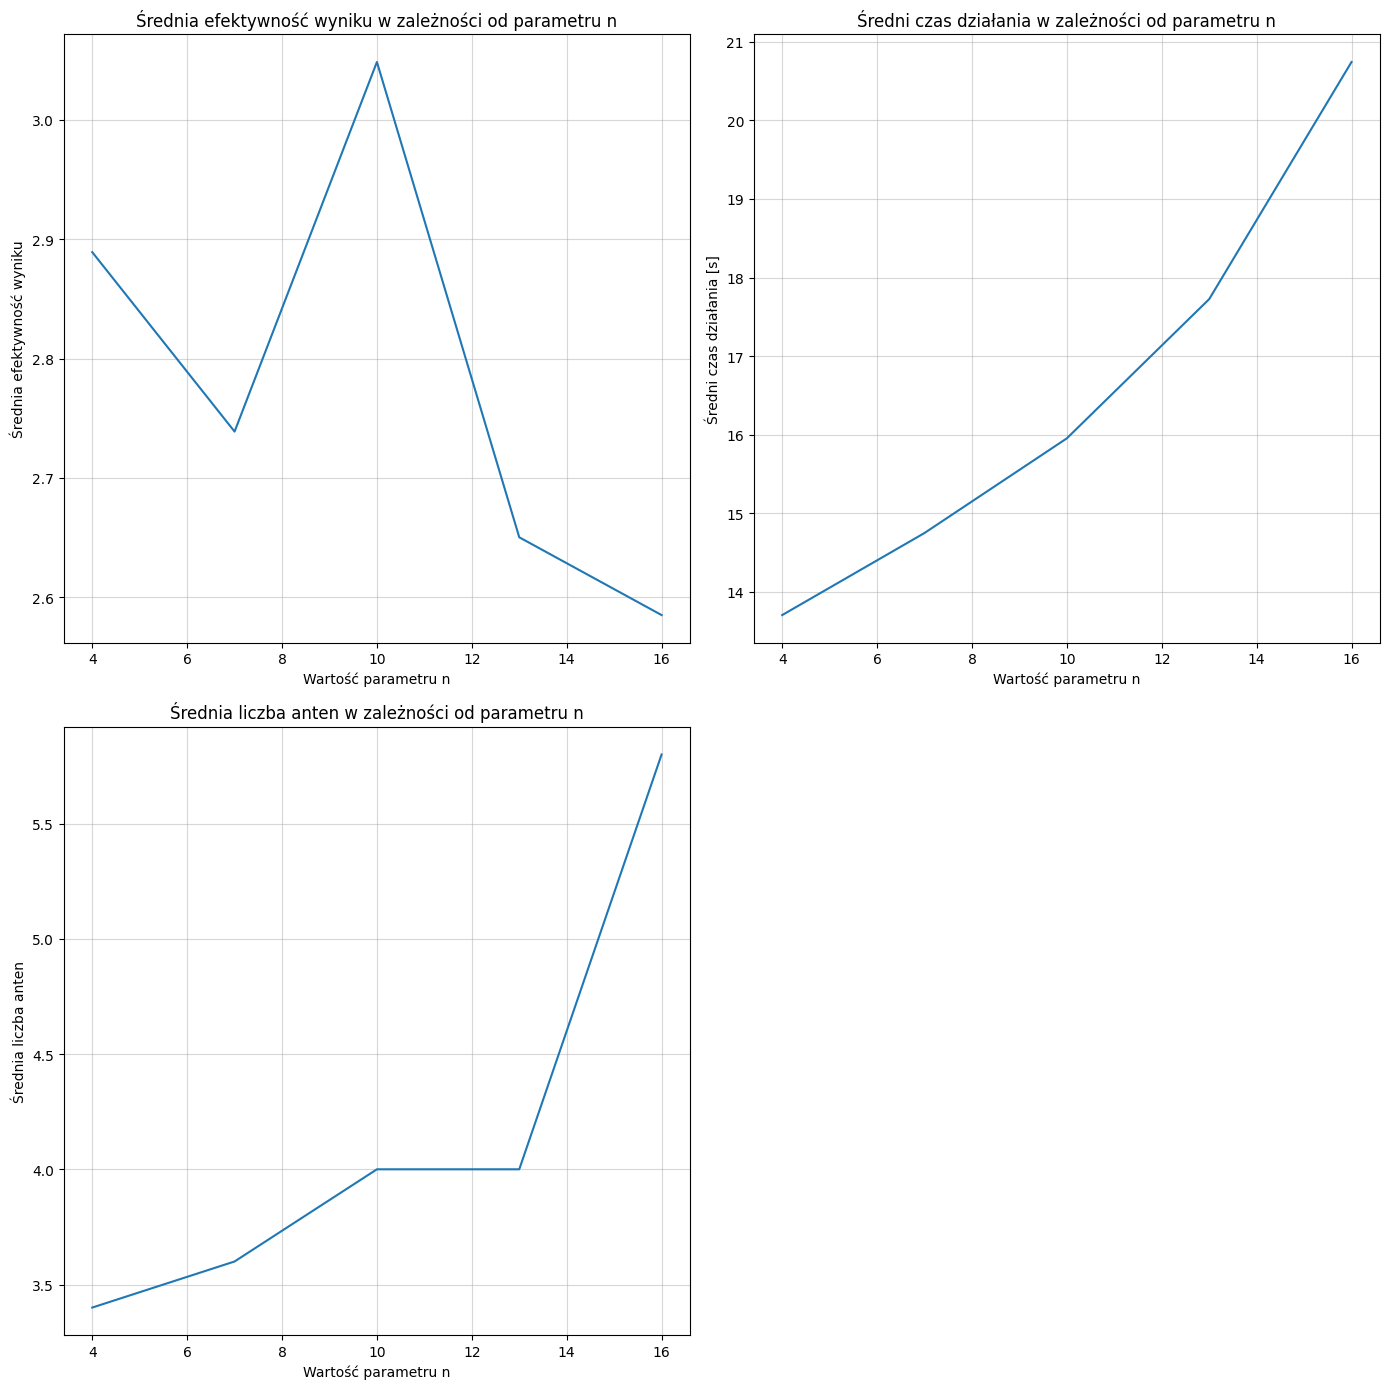

In [49]:
run_analysis("n", 4, 19, 3)

#### **Wnioski**

Wykres pierwszy pokazuje, że wysoka maksymalna ilośc anten wpływa niekorzystnie na efektywność rozmieszczenia anten. Wynika to najprawdopodobniej z tego, że każda antena to dodatkowy koszt, a wcześniejsze analizy pokazały, że wystarczy ich jedynie ok. 4 żeby pokryć dobrze sieć.

Zwiększony czas działania na wykresie drugim jest oczywistym efektem tego, że każdy osobnik ma w sobie więcej anten, a oznacza to większą ilosć obliczeń dla programu.

Trzeci wykres również obrazuje oczywisty wniosek - im więcej może pojawić się anten, tym więcej ich będzie.

### **Parametr $M$**

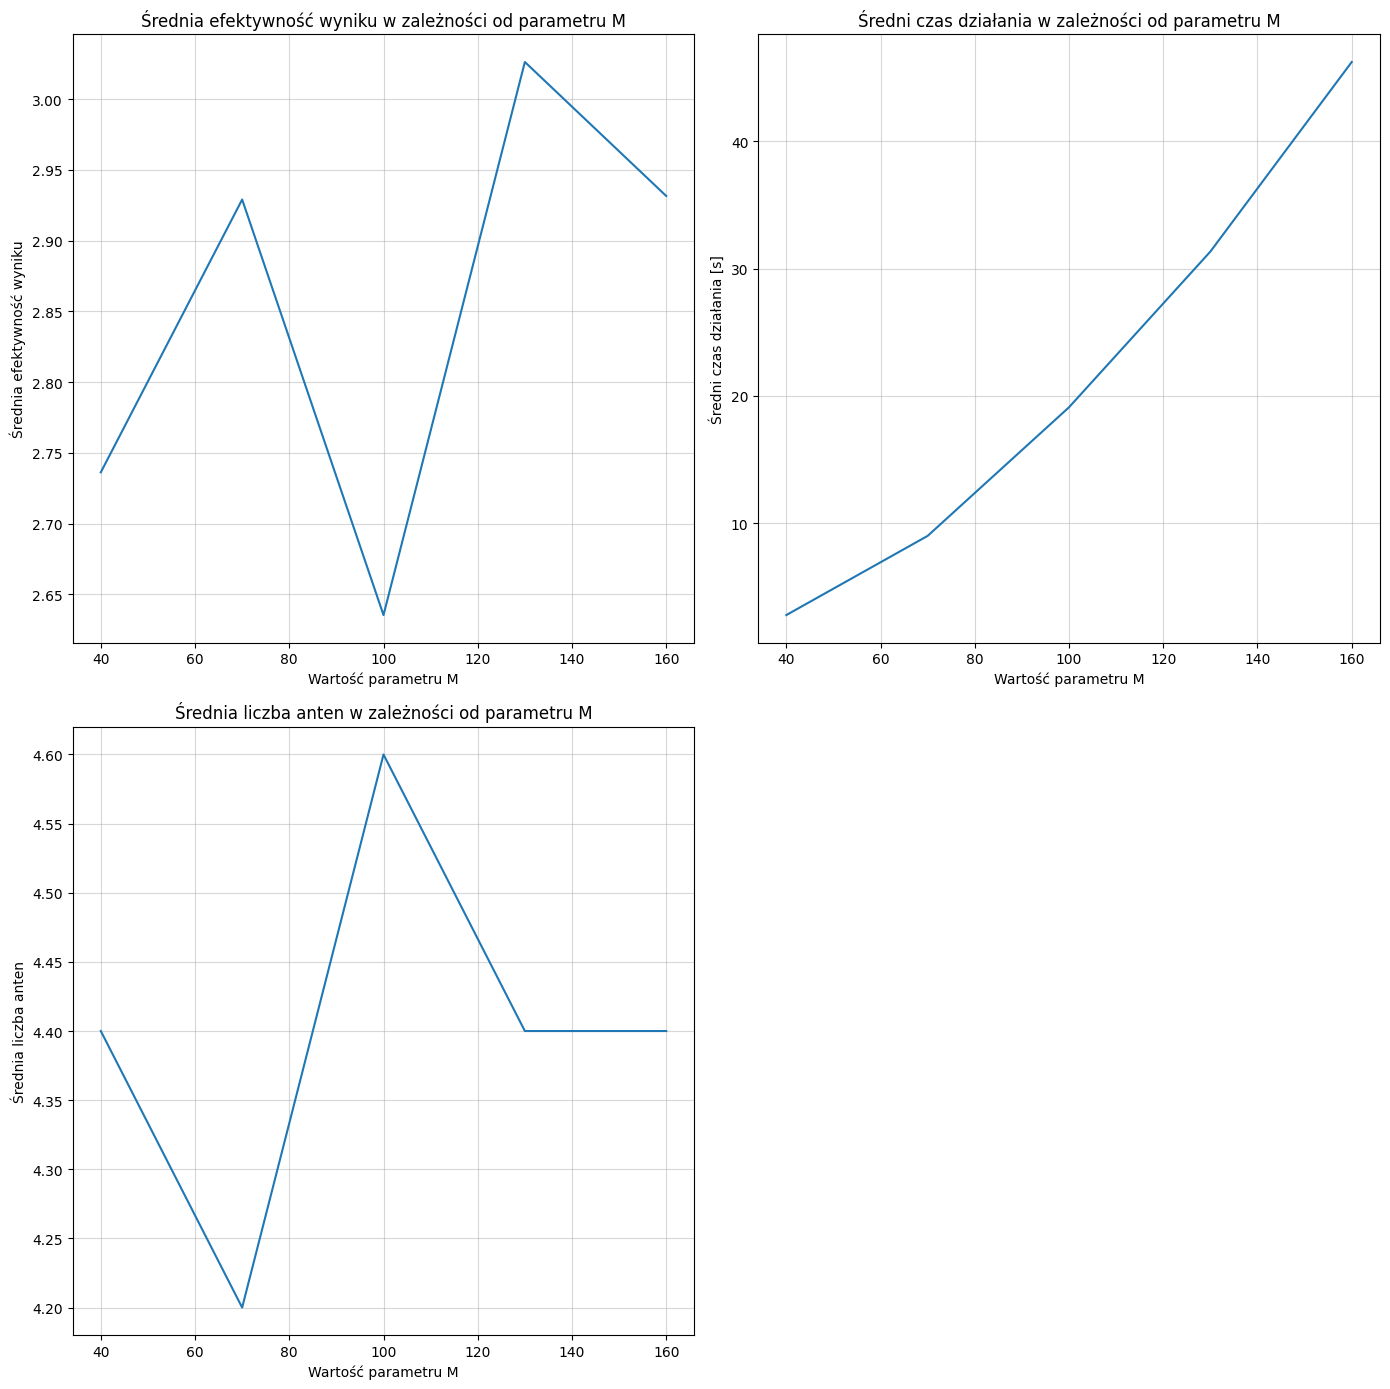

In [50]:
run_analysis("M", 40, 190, 30)

#### **Wnioski**

Wyniki na wykresie pierwszym i trzecim wskazują na to, że dokładność siatki nie wpływa jednoznacznie na rozwiązanie. Wyniki są różne, ale pozostają zbliżone do wyników dla parametrów domyślnych.

Bardzo dużej zmianie podlega czas wykonywania programu. Jest to wynikiem tego, że dla dużych wartości parametru $M$ funkcja coverage musi wykonać znacznie większą ilość operacji i czas wykonania staje się dotkliwie duży.

## **Wnioski końcowe**

Podsumowując analizę algorytmu mam kilka wniosków:
- Dla domyślnych parametrów optymalna ilośc anten to ok. 4, a optymalny wynik to ok. 3.3,
- Algorytm ma bardzo wiele elementów losowych dlatego wcześniejsze generacje mogą okazać się lepsze od najpóźniejszych (w teorii najlepiej wyewoluowanych),
- Sukcesja generacyjna sprawia, że z każdą generacją istnieje ryzyko przepadnięcia bezpowrotnie dobrych osobników. Jest to jednym z powodów wniosku wyżej,
- Jeśli interesuje nas czas działania algorytmu, trzeba szczególnie uważać na parametr $M$ oraz ilość generacji. Ich zwiększenie najbardziej wpływa na przedłużenie czasu działania do bardzo dużych wartości,
- Na jakość rozwiązania korzystnie wpływa duża ilośc generacji, mała siła mutacji, duża ilość selekcji i mała szansa na dodanie anteny do osobnika. Taki dobór parametrów minimalizuje szanse na negatywne wyniki wszechobecnych losowań i daje algorytmowi więcej prób na poprawę populacji. Nie wspominam tutaj o parametrach $R, w1, w2$, ponieważ zmienianie ich to wpływanie na zewnętrzne parametry, a nie na działanie samego algorytmu, ale ich wpływ na wyniki jest oczywiście wysoki,
- Ciekawym spostrzezeniem jest brak jednoznacznego wpływu rozmiaru populacji startowej na wynik algorytmu.